In [1]:
# %load_ext cudf.pandas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import cohen_kappa_score # To calculate quadratic weighted Kappa

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline

from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from catboost import CatBoostRegressor

from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
running_locally = True
rerun_series = False

# Uncomment this if submitting to Kaggle. Need to install the library for TabNet as it isn't natively offered in the Kaggle environment
# !pip install --no-index --find-links=/kaggle/input/pytorch-tabnet-4-1-0-py3-none-any-whl /kaggle/input/pytorch-tabnet-4-1-0-py3-none-any-whl/pytorch_tabnet-4.1.0-py3-none-any.whl

In [3]:
if running_locally:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    data_dictionary = pd.read_csv('data_dictionary.csv')
    sample = pd.read_csv('sample_submission.csv')
else:
    train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
    sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')


In [4]:
train_df.describe()

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287   
min          33.000000         0.000000                     18.000000   
25%          50.000000        57.200000                     23.000000   
50%          55.000000        77.000000                     26.000000   
75%          62.000000       113.800000                     30.000000   
max          78.500000       315.000000                     50.000000   

       Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
count            2954.000000         2967.000000           2954.000000   
mean               69.648951           81.597236            116.983074   
std                13.611226           13.665196             17.061225   
min                 0.000000           27.000000              0.000000   
25%                61.000000           72.000000            107.000000   
50%                68.000000           81.000000            114.000000   
75%                76.000000           90.500000            125.000000   
max               179.000000          138.000000            203.000000   

       Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
count                   743.000000                   740.000000   
mean                      4.989233                     7.370270   
std                       2.014072                     3.189662   
min                       0.000000                     0.000000   
25%                       4.000000                     6.000000   
50%                       5.000000                     7.000000   
75%                       6.000000                     9.000000   
max                      28.000000                    20.000000   

       Fitness_Endurance-Time_Sec   FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  \
count                  740.000000  2322.000000      2282.000000   1074.000000   
mean                    27.581081    11.259690         0.476337     22.420438   
std                     17.707751    11.807781         0.499549     10.833995   
min                      0.000000     0.000000         0.000000      0.000000   
25%                     12.750000     3.000000         0.000000     15.100000   
50%                     28.000000     9.000000         0.000000     20.050000   
75%                     43.000000    15.750000         1.000000     26.600000   
max                     59.000000   115.000000         1.000000    124.000000   

       FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone   FGC-FGC_PU  \
count        1062.000000  1074.000000       1063.000000  2310.000000   
mean            1.829567    23.518622          1.904045     5.579654   
std             0.612585    11.148951          0.612344     7.390161   
min             1.000000     0.000000          1.000000     0.000000   
25%             1.000000    16.200000          2.000000     0.000000   
50%             2.000000    21.200000          2.000000     3.000000   
75%             2.000000    28.175000          2.000000     9.000000   
max             3.000000   123.800000          3.000000    51.000000   

       FGC-FGC_PU_Zone  FGC-FGC_

# Exploratory Data Analysis

### Severity Impairment Index
First, we'll look at the distribution of `sii` data

In [5]:
sii_data = train_df['sii'].value_counts().reset_index()
sii_data.columns = ['sii_label', 'count']
sii_data['percent_of_total'] = round((sii_data['count'] / len(train_df)) * 100,1)
sii_data
print(f"{sii_data}\n")
print(f"{100.0*train_df['sii'].isnull().sum()/len(train_df):.2f}% of the sii data is null")

   sii_label  count  percent_of_total
0        0.0   1594              40.3
1        1.0    730              18.4
2        2.0    378               9.5
3        3.0     34               0.9

30.91% of the sii data is null


### Demographics
Let's look through the data related to demographics

In [6]:
train_df['Basic_Demos-Sex'].value_counts()

Basic_Demos-Sex
0    2484
1    1476
Name: count, dtype: int64

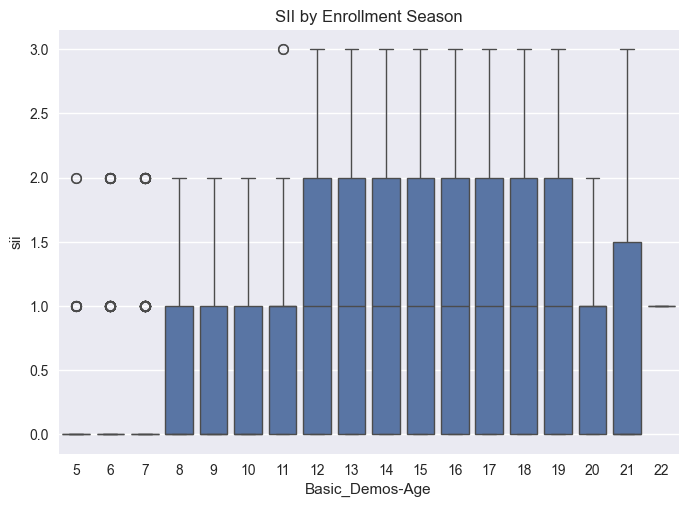

In [7]:
plt.style.use('seaborn-v0_8')
sns.boxplot(x='Basic_Demos-Age', y='sii', data=train_df)
plt.title('SII by Enrollment Season')

plt.show()

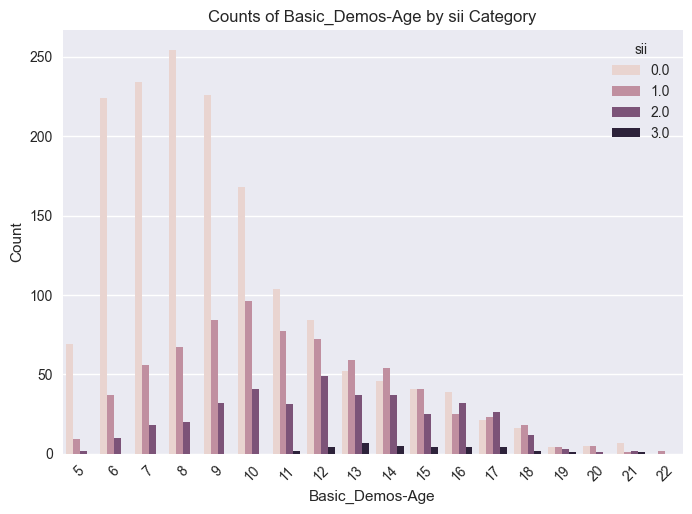

In [8]:
age_sii_counts = train_df.groupby(['Basic_Demos-Age', 'sii']).size().reset_index(name='count')
sns.barplot(data=age_sii_counts, x='Basic_Demos-Age', y='count', hue='sii')
plt.title('Counts of Basic_Demos-Age by sii Category')
plt.xlabel('Basic_Demos-Age')
plt.ylabel('Count')
plt.legend(title='sii')
plt.xticks(rotation=45)
plt.show()

Here's what we learned:
* We learned that our dataset is mostly males, about 63% male to 37% female
* Also, the interquartile range of `sii` increases with older ages. 
* Younger ages are prone to less severe impairment
* The magnitude of the severity changes based on the age in consideration. E.g.
    * 0 risk -> 8 yrs old
    * 1 risk -> 10 yrs old
    * 2 risk -> 12 yrs old
    * 3 risk -> 13 yrs old

### Children's Global Assessment Scale

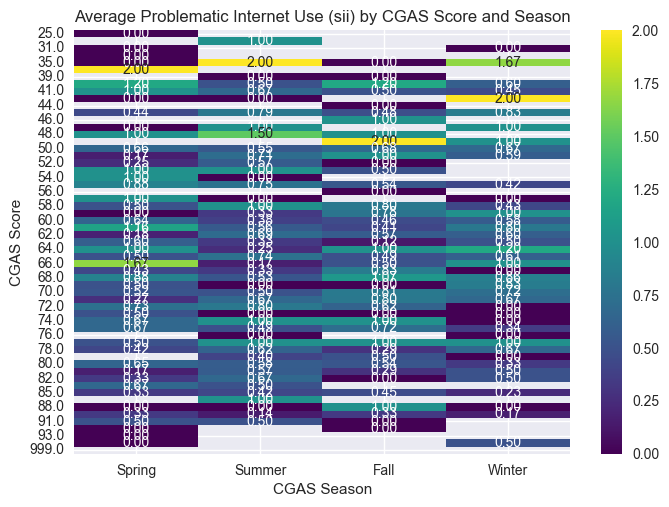

In [9]:
heatmap_data = train_df.groupby(['CGAS-CGAS_Score', 'CGAS-Season'])['sii'].mean().reset_index()
heatmap_data = heatmap_data.pivot(index='CGAS-CGAS_Score', columns='CGAS-Season', values='sii')
column_order = ["Spring", "Summer", "Fall", "Winter"]
heatmap_data = heatmap_data.reindex(columns=column_order) # want the seasons to be in chronological
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f") 
plt.title('Average Problematic Internet Use (sii) by CGAS Score and Season')
plt.xlabel('CGAS Season')
plt.ylabel('CGAS Score')
plt.show()

No notable trends seen in the Children's Global Assessment Scale. Let's move on to the next instrument

### Physical Measures

In [10]:
phys_cols = list(train_df.filter(like='Physical-').columns) + ['sii']
train_df[phys_cols].describe()

Physical-BMI  Physical-Height  Physical-Weight  \
count   3022.000000      3027.000000      3076.000000   
mean      19.331929        55.946713        89.038615   
std        5.113934         7.473764        44.569040   
min        0.000000        33.000000         0.000000   
25%       15.869350        50.000000        57.200000   
50%       17.937682        55.000000        77.000000   
75%       21.571244        62.000000       113.800000   
max       59.132048        78.500000       315.000000   

       Physical-Waist_Circumference  Physical-Diastolic_BP  \
count                    898.000000            2954.000000   
mean                      27.278508              69.648951   
std                        5.567287              13.611226   
min                       18.000000               0.000000   
25%                       23.000000              61.000000   
50%                       26.000000              68.000000   
75%                       30.000000              76.000000   
max                       50.000000             179.000000   

       Physical-HeartRate  Physical-Systolic_BP          sii  
count         2967.000000           2954.000000  2736.000000  
mean            81.597236            116.983074     0.580409  
std             13.665196             17.061225     0.771122  
min             27.000000              0.000000     0.000000  
25%             72.000000            107.000000     0.000000  
50%             81.000000            114.000000     0.000000  
75%             90.500000            125.000000     1.000000  
max            138.000000            203.000000     3.000000

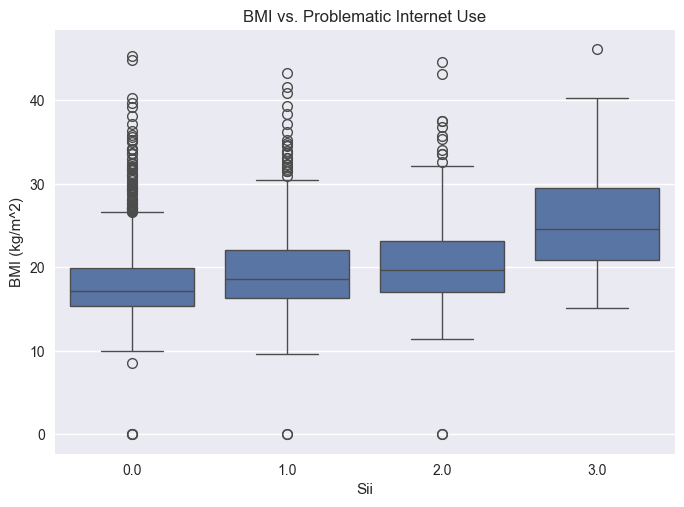

In [11]:
sns.boxplot(x='sii', y='Physical-BMI', data=train_df)
plt.title('BMI vs. Problematic Internet Use')
plt.xlabel('Sii')
plt.ylabel('BMI (kg/m^2)')
plt.show()


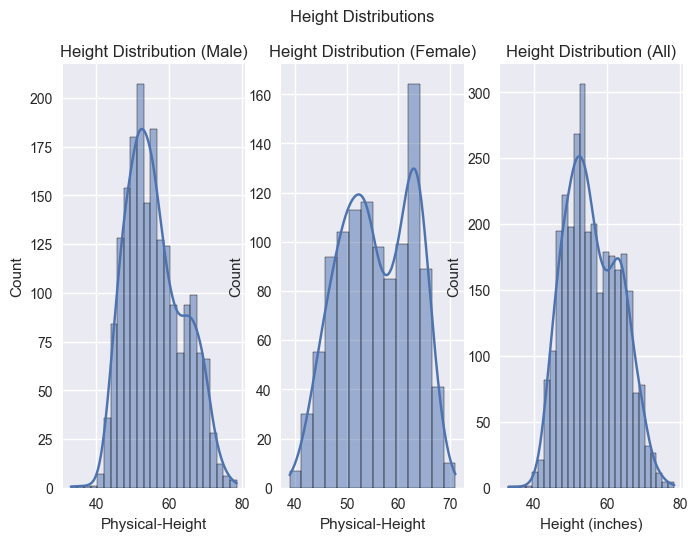

In [12]:
fig, axes = plt.subplots(1, 3)
sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 0]['Physical-Height'], kde=True, ax=axes[0])
axes[0].set_title('Height Distribution (Male)')

sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 1]['Physical-Height'], kde=True, ax=axes[1])
axes[1].set_title('Height Distribution (Female)')

sns.histplot(train_df['Physical-Height'], kde=True, ax=axes[2])
axes[2].set_title('Height Distribution (All)')

plt.suptitle('Height Distributions')
plt.xlabel('Height (inches)')
plt.show()

Here's what we learned: 
- Higher BMI corresponds to higher `sii`. The 50 percentile of BMI for "Severe" sii is higher than the 75 percentile for "Moderate" sii
- There was minimal variance in the season w.r.t. the `sii`
- The distribution of heights seemed to take on the form of a bimodal distribution instead of a typical normal distribution. This is likely because males and females are different heights, so the resulting histogram has 2 peaks. The males are the shorter peak because they are typically shorter in the age range collected in this dataset.

### FitnessGram Vitals and Treadmill

In [13]:
fitness_endurance_cols = list(train_df.filter(like='Fitness_Endurance-').columns) + ['sii']
train_df[fitness_endurance_cols].describe()

Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
count                   743.000000                   740.000000   
mean                      4.989233                     7.370270   
std                       2.014072                     3.189662   
min                       0.000000                     0.000000   
25%                       4.000000                     6.000000   
50%                       5.000000                     7.000000   
75%                       6.000000                     9.000000   
max                      28.000000                    20.000000   

       Fitness_Endurance-Time_Sec          sii  
count                  740.000000  2736.000000  
mean                    27.581081     0.580409  
std                     17.707751     0.771122  
min                      0.000000     0.000000  
25%                     12.750000     0.000000  
50%                     28.000000     0.000000  
75%                     43.000000     1.000000  
max                     59.000000     3.000000

In [14]:
# Hardcode the columns to avoid the category columns
train_df[['Fitness_Endurance-Max_Stage','Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec','sii']].corr()

Fitness_Endurance-Max_Stage  \
Fitness_Endurance-Max_Stage                     1.000000   
Fitness_Endurance-Time_Mins                     0.873138   
Fitness_Endurance-Time_Sec                     -0.138393   
sii                                            -0.070589   

                             Fitness_Endurance-Time_Mins  \
Fitness_Endurance-Max_Stage                     0.873138   
Fitness_Endurance-Time_Mins                     1.000000   
Fitness_Endurance-Time_Sec                     -0.201425   
sii                                            -0.060628   

                             Fitness_Endurance-Time_Sec       sii  
Fitness_Endurance-Max_Stage                   -0.138393 -0.070589  
Fitness_Endurance-Time_Mins                   -0.201425 -0.060628  
Fitness_Endurance-Time_Sec                     1.000000  0.008701  
sii                                            0.008701  1.000000

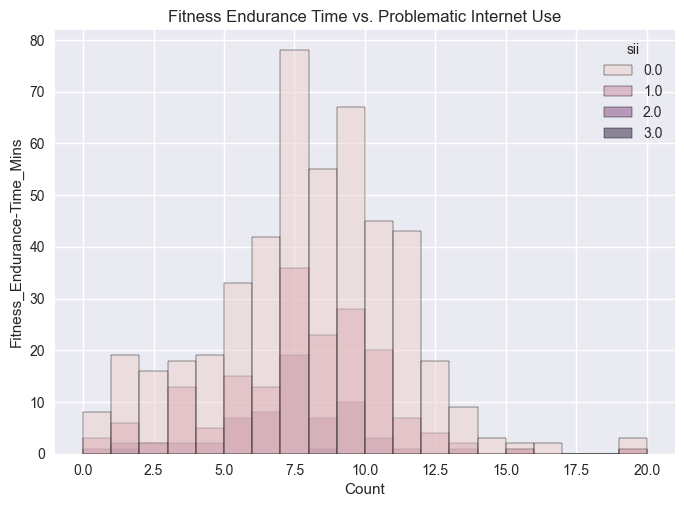

In [15]:
sns.histplot(train_df, x='Fitness_Endurance-Time_Mins',bins=20, hue='sii')
plt.title('Fitness Endurance Time vs. Problematic Internet Use')
plt.xlabel('Count')
plt.ylabel('Fitness_Endurance-Time_Mins')
plt.show()

Here's what we learned:
- `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` should be combined into 1 column. This will be done later
- There wasnt a strong correlation with any of these columns and `sii`

### FitnessGram Child

In [16]:
fgc_cols = list(train_df.filter(like='FGC').columns) + ['sii']
train_df[fgc_cols].describe()

FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
count  2322.000000      2282.000000   1074.000000        1062.000000   
mean     11.259690         0.476337     22.420438           1.829567   
std      11.807781         0.499549     10.833995           0.612585   
min       0.000000         0.000000      0.000000           1.000000   
25%       3.000000         0.000000     15.100000           1.000000   
50%       9.000000         0.000000     20.050000           2.000000   
75%      15.750000         1.000000     26.600000           2.000000   
max     115.000000         1.000000    124.000000           3.000000   

       FGC-FGC_GSD  FGC-FGC_GSD_Zone   FGC-FGC_PU  FGC-FGC_PU_Zone  \
count  1074.000000       1063.000000  2310.000000      2271.000000   
mean     23.518622          1.904045     5.579654         0.330251   
std      11.148951          0.612344     7.390161         0.470407   
min       0.000000          1.000000     0.000000         0.000000   
25%      16.200000          2.000000     0.000000         0.000000   
50%      21.200000          2.000000     3.000000         0.000000   
75%      28.175000          2.000000     9.000000         1.000000   
max     123.800000          3.000000    51.000000         1.000000   

       FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  \
count  2305.000000       2267.000000  2307.000000       2269.000000   
mean      8.694924          0.618880     8.805635          0.620097   
std       3.429301          0.485769     3.422167          0.485469   
min       0.000000          0.000000     0.000000          0.000000   
25%       7.000000          0.000000     7.000000          0.000000   
50%       9.000000          1.000000     9.000000          1.000000   
75%      11.000000          1.000000    11.000000          1.000000   
max      21.700000          1.000000    21.000000          1.000000   

        FGC-FGC_TL  FGC-FGC_TL_Zone          sii  
count  2324.000000      2285.000000  2736.000000  
mean      9.252775         0.785558     0.580409  
std       2.988863         0.410525     0.771122  
min       0.000000         0.000000     0.000000  
25%       7.000000         1.000000     0.000000  
50%      10.000000         1.000000     0.000000  
75%      12.000000         1.000000     1.000000  
max      22.000000         1.000000     3.000000

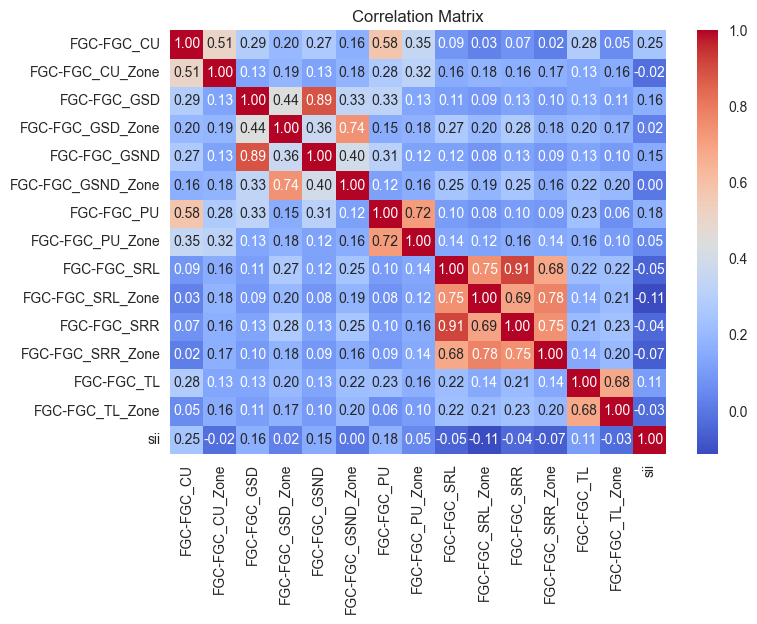

In [17]:
corr_matrix = train_df[fgc_cols].drop(columns=['FGC-Season']).corr()
sorted_cols = corr_matrix.columns.sort_values()
sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Here's what we learned:
- Interestingly, there isn't as high of a correlation between the raw values and the categorized "zones". 
    - The highest observed correlation between a category and its zone was only 0.75 for `FGC_FGC_SRR` and `FGC_FGC_SRL`. (These two measurements are just the left and right legs of the Sit & Reach.)

### Bio-electric Impedance Analysis

In [18]:
bia_cols = list(train_df.filter(like='BIA-').columns) + ['sii']
train_df[bia_cols].describe()

BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI   BIA-BIA_BMR  \
count                 1991.000000  1991.000000  1991.000000   1991.000000   
mean                     2.651431     6.719826    19.367048   1237.018187   
std                      1.028267    92.586325     5.047848   1872.383246   
min                      1.000000    -7.789610     0.048267    813.397000   
25%                      2.000000     2.966905    15.913600   1004.710000   
50%                      3.000000     3.922720    17.966500   1115.380000   
75%                      3.000000     5.460925    21.461100   1310.360000   
max                      5.000000  4115.360000    53.924300  83152.200000   

         BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  BIA-BIA_FMI  \
count    1991.000000  1991.000000  1991.000000   1991.000000  1991.000000   
mean     2064.693747    20.825346    74.021708     15.030554     4.336495   
std      2836.246272    73.266287   199.433753      5.792505     6.356402   
min      1073.450000     1.789450    28.900400      7.864850  -194.163000   
25%      1605.785000    11.109550    49.278100     13.408000     2.306915   
50%      1863.980000    15.928000    61.066200     14.092500     3.698630   
75%      2218.145000    25.162200    81.833800     15.430950     5.987690   
max    124728.000000  3233.000000  8799.080000    217.771000    28.251500   

       BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_LST  \
count  1991.000000        1991.000000  1991.000000   1991.00000  1991.000000   
mean     16.855020           1.745354    33.173380     20.02299    67.301883   
std     199.372119           0.680635    56.272346     70.21561   108.705918   
min   -8745.080000           1.000000    14.489000      4.63581    23.620100   
25%       8.602395           1.000000    24.463500     12.98315    45.204100   
50%      16.174600           2.000000    28.855800     16.43880    56.996400   
75%      30.273100           2.000000    35.475700     22.16760    77.105650   
max     153.820000           3.000000  2457.910000   3108.17000  4683.710000   

       BIA-BIA_SMM  BIA-BIA_TBW          sii  
count  1991.000000  1991.000000  2736.000000  
mean     34.389466    53.998726     0.580409  
std      84.050607   129.362539     0.771122  
min       4.655730    20.589200     0.000000  
25%      21.141550    35.887000     0.000000  
50%      27.415100    44.987000     0.000000  
75%      38.179400    60.271050     1.000000  
max    3607.690000  5690.910000     3.000000

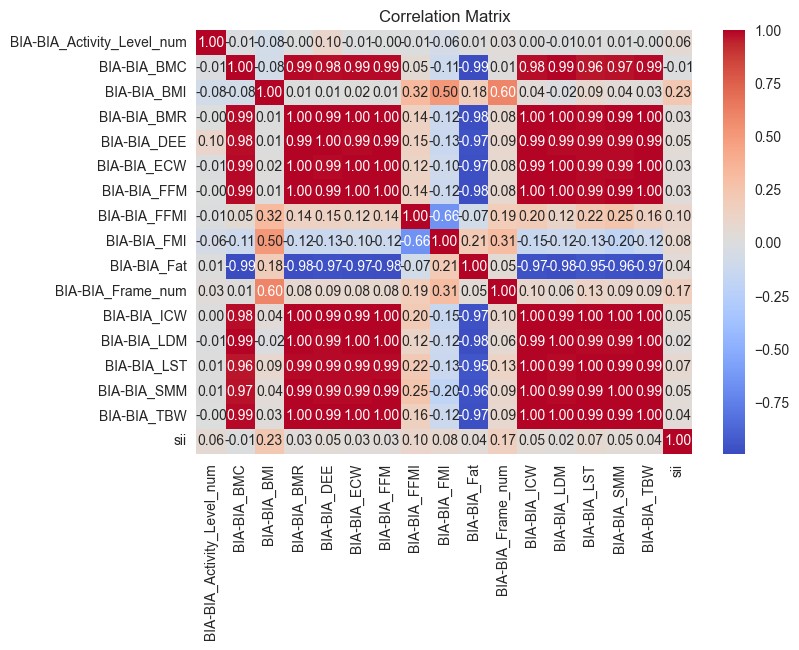

In [19]:
bia_corr_matrix = train_df[bia_cols].drop(columns=['BIA-Season']).corr()
bia_sorted_cols = bia_corr_matrix.columns.sort_values()
bia_sorted_corr_matrix = bia_corr_matrix.loc[bia_sorted_cols, bia_sorted_cols]

sns.heatmap(bia_sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

We can clearly see that there are some highly correlated features. Let's explore that a bit more

In [20]:
correlated_bia_features = ['BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_Fat','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW']
all_bia_features = ['BIA-BIA_BMC','BIA-BIA_BMI','BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_FFMI','BIA-BIA_FMI','BIA-BIA_Fat','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW']

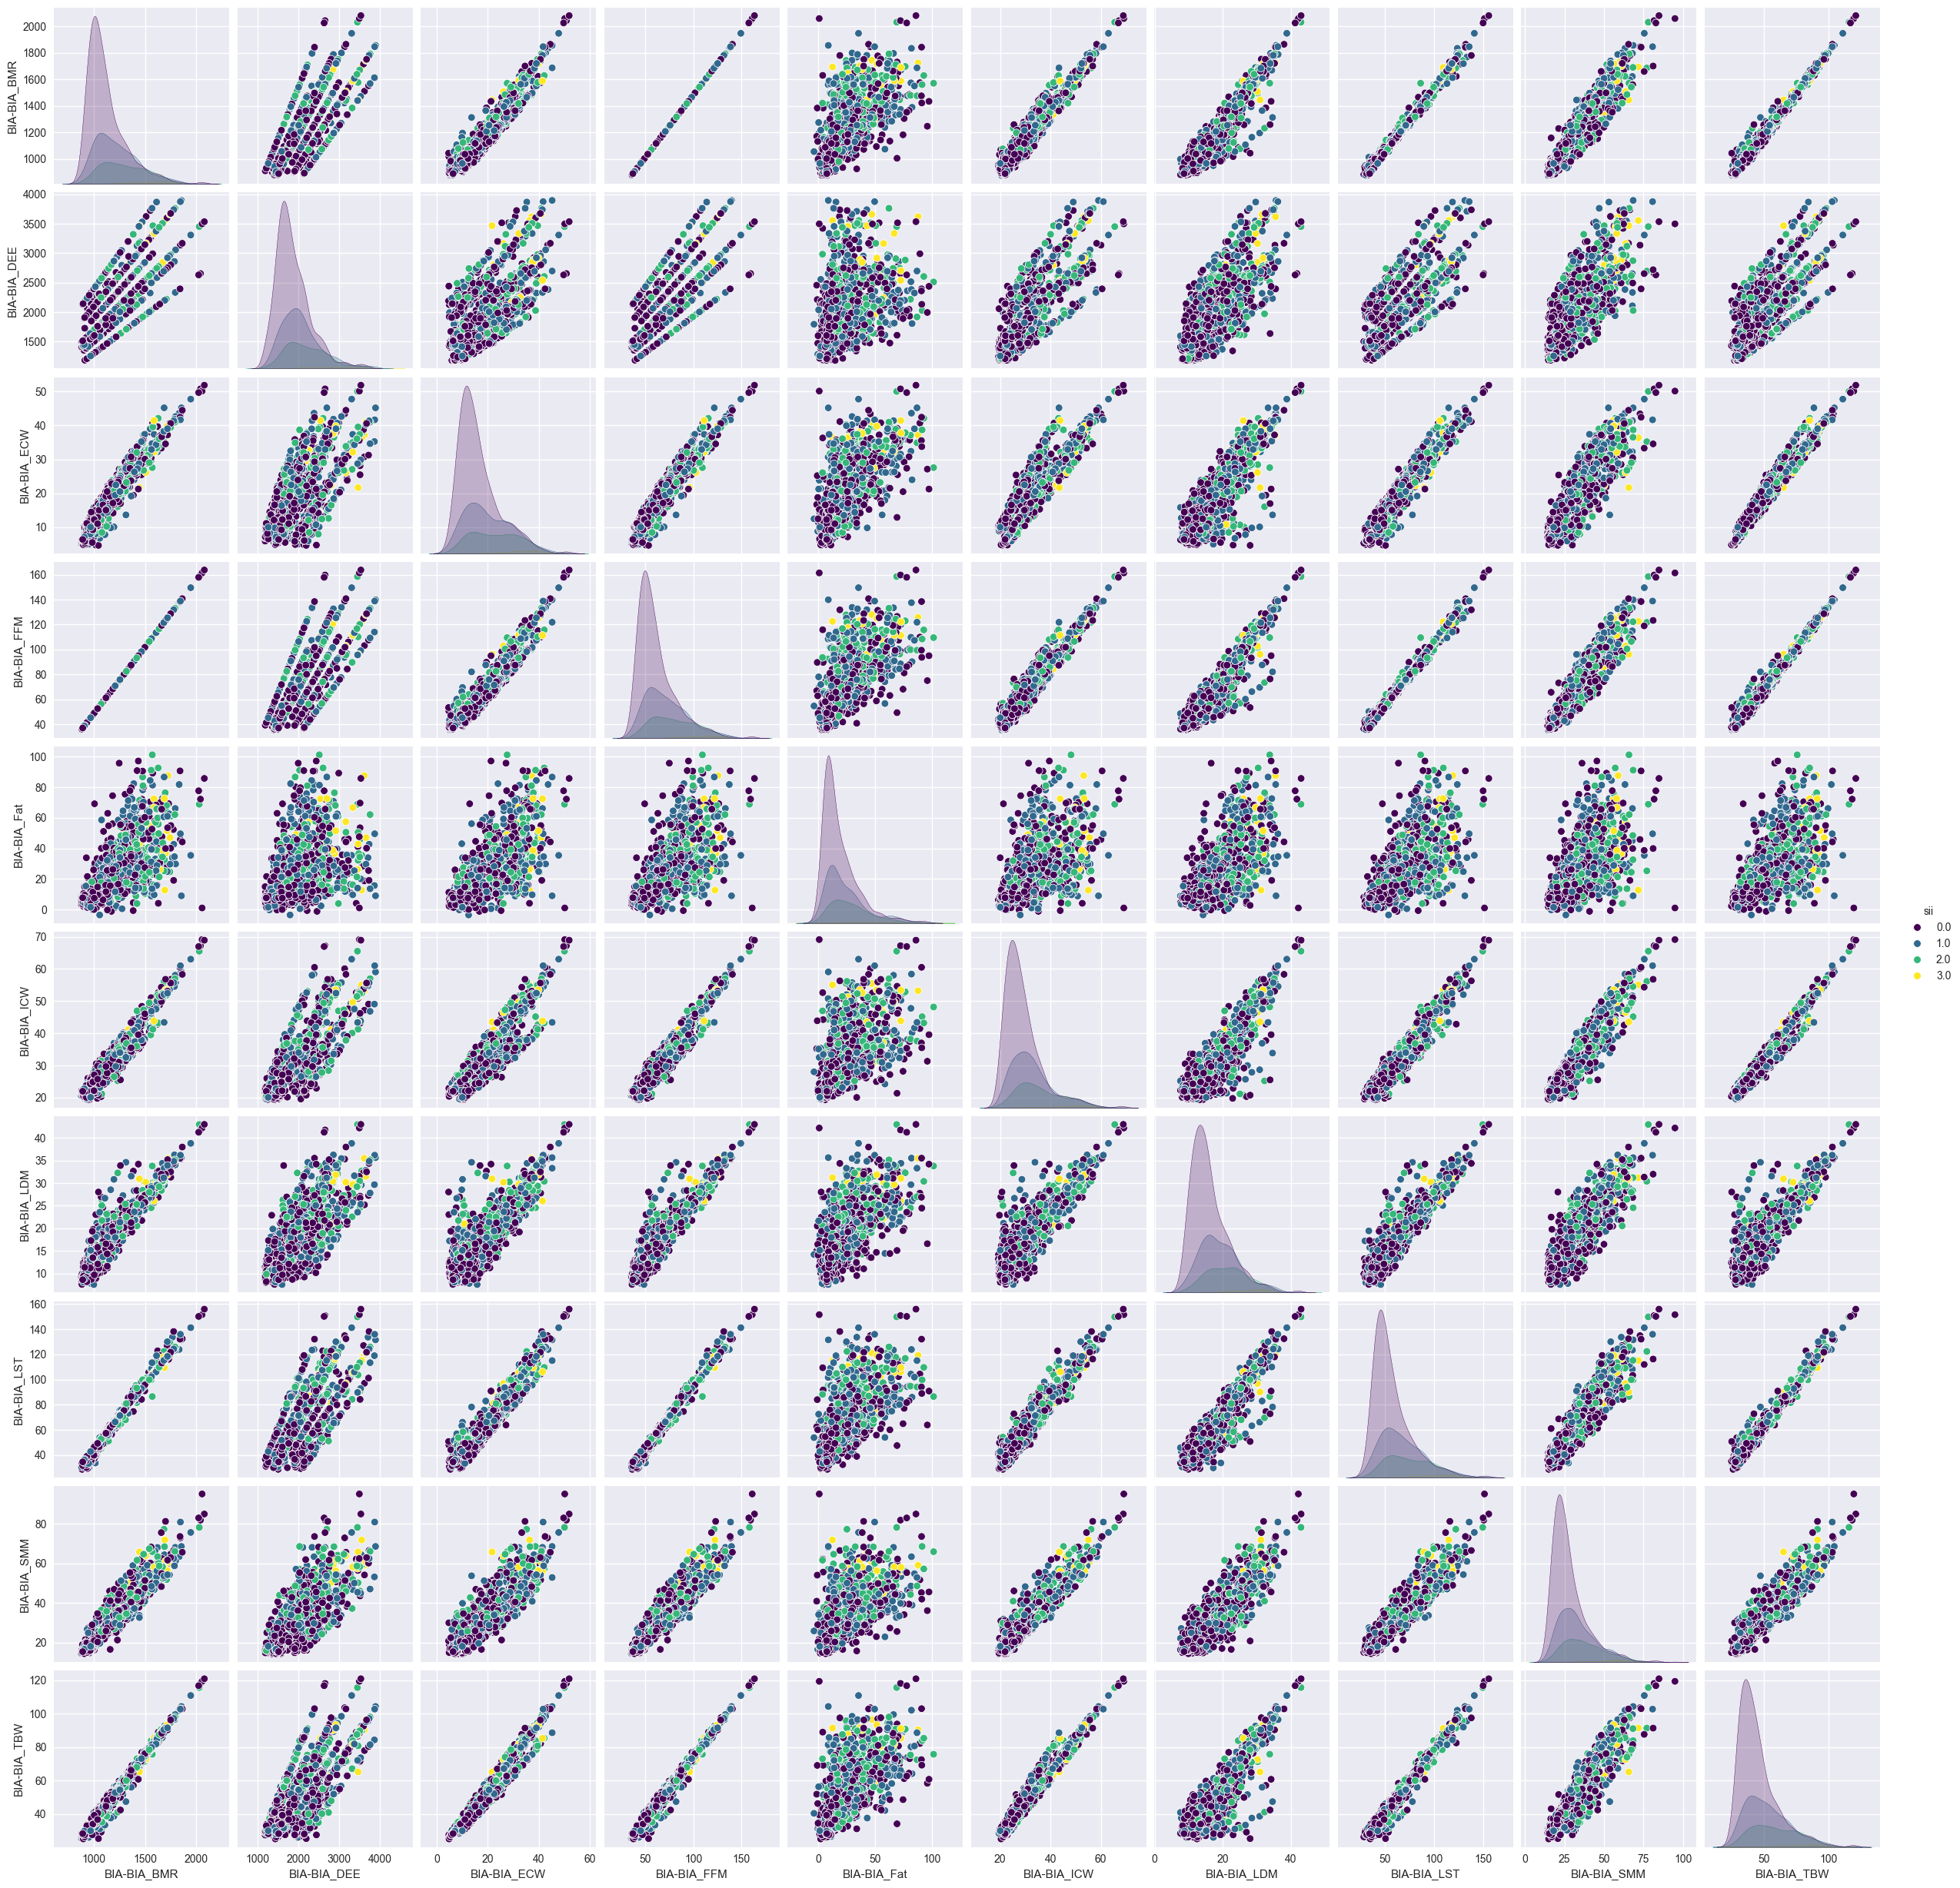

In [21]:
pairplot_features = correlated_bia_features + ['sii']

# Filter out outliers for the pairplot features. There is one record that obscures all the visualizations
filtered_df = train_df[
    train_df[pairplot_features].apply(lambda x: x.between(x.quantile(0.01), x.quantile(0.99))).all(axis=1)
]

sns.pairplot(filtered_df[pairplot_features], hue='sii', palette='viridis')

Here's what we learned:
- Body Fat Percentage is inversely correlated to most BIA fields, i.e. Bone Mineral Content, Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, Fat Free Mass, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, Total Body Water.
- Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, and Fat Free Mass are all correlated to each other.
- Similarly, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, and Total Body Water are correlated to each other
- No one attribute correlates to `sii`

### Physical Activity Questionnaire

Text(0.5, 1.0, 'Physical Activity Questionnaire (Children)')

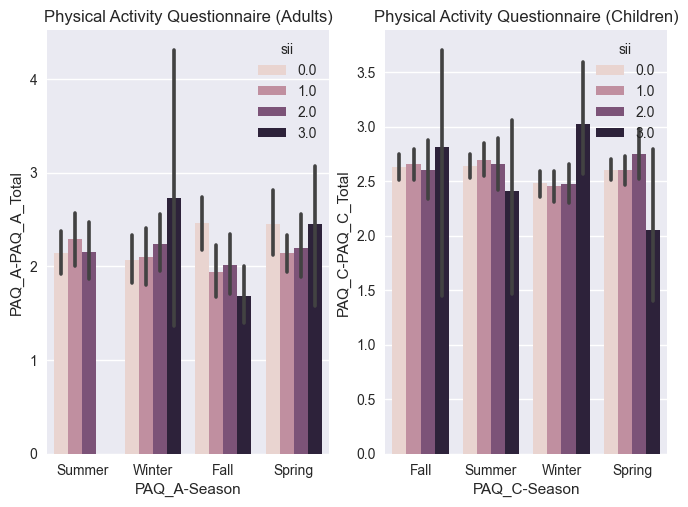

In [22]:
fig, axes = plt.subplots(1,2)
sns.barplot(data=train_df, x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', hue='sii', ax=axes[0])
axes[0].set_title('Physical Activity Questionnaire (Adults)')

sns.barplot(data=train_df, x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', hue='sii', ax=axes[1])
axes[1].set_title('Physical Activity Questionnaire (Children)')

Here's what we learned:
- There are no adults with a "severe" `sii` rating in the Summer.
- Winter was the season with the most "severe" `sii` ratings for children, but it was the season with the fewest "severe" `sii` ratings for adults. 

### Parent-Child Internet Addiction Test

In [23]:
pciat_aggs = train_df.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean'])
pciat_aggs = pciat_aggs.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score', 'mean': 'Average total PCIAT Score'}
)
pciat_aggs

Minimum PCIAT total Score  Maximum total PCIAT Score  \
sii                                                         
0.0                        0.0                       30.0   
1.0                       31.0                       49.0   
2.0                       50.0                       79.0   
3.0                       80.0                       93.0   

     Average total PCIAT Score  
sii                             
0.0                  13.929737  
1.0                  38.726027  
2.0                  60.658730  
3.0                  85.911765

In [24]:
# List all columns that are of the form PCIAT-PCIAT_XX
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

pciat_summed_total = train_df[pciat_columns].fillna(0).sum(axis=1)
is_calculated_sum_equal_to_total_column = pciat_summed_total == train_df['PCIAT-PCIAT_Total'].fillna(0)

# Check if sum of the scores equals total for all rows
is_calculated_sum_equal_to_total_column.sum() == len(train_df)


True

Here's what we learned:
- The average of the scores for each `sii` classification was around the median of the bounds of the range (e.g. n `sii` of 0 is from 0-30, and the average score was ~14)
- The sum of the PCIAT scores all align with the classification set by the Severity Impairment Index (sii).
- The number of instances where PCIAT-PCIAT_1 through PCIAT-PCIAT_20 is equal to PCIAT-PCIAT_Total is equal to the number of records in the dataset. This shows that PCIAT-PCIAT_Total is 100% is a linear transformation of other features in this dataset, so we can drop it from the dataset later. However, many of the columns are `nan`. This means that if an entry's sum is 30 but, for instance, there are 10 `nan` values, that record is likely misclassified. We will account for this in the Feature Engineering section.

Also, note that the **test** set does not have any of the PCIAT data, and we're missing about 30% of the `sii` label in the training data. 

### Sleep Disturbance Scale

In [25]:
sds_cols = list(train_df.filter(like='SDS-').columns) + ['sii']
train_df[sds_cols].drop(columns=['sii']).isnull().sum()/train_df[['SDS-Season','SDS-SDS_Total_Raw','SDS-SDS_Total_T']].notnull().sum()

SDS-Season           0.512605
SDS-SDS_Total_Raw    0.517823
SDS-SDS_Total_T      0.519570
dtype: float64

In [26]:
# Hardcode to omit the category columns
train_df[['SDS-SDS_Total_Raw','SDS-SDS_Total_T']].corr()

SDS-SDS_Total_Raw  SDS-SDS_Total_T
SDS-SDS_Total_Raw           1.000000         0.996134
SDS-SDS_Total_T             0.996134         1.000000

Here's what we learned:
- About half of the sleep data is null
- There is an extremely strong correlation between the Total Raw Score and Total T-score. We will remove one in the Feature Engineering Section

### Internet Use

In [27]:
int_use = list(train_df.filter(like='PreInt_EduHx-').columns) + ['sii']
train_df[int_use].drop(columns='PreInt_EduHx-Season').corr()

PreInt_EduHx-computerinternet_hoursday  \
PreInt_EduHx-computerinternet_hoursday                                1.000000   
sii                                                                   0.336526   

                                             sii  
PreInt_EduHx-computerinternet_hoursday  0.336526  
sii                                     1.000000

Here's what we learned:
- There is a weak correlation between Hours of Using Computer/Internet and `sii`. This is the strongest correlation we have seen so far between a raw column and `sii`.

## Process Actigraphy Data

In [28]:
if rerun_series:
    def process_file(filename, dirname):
        data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
        data.drop('step', axis=1, inplace=True)
        return data.describe().values.reshape(-1), filename.split('=')[1]

    def load_time_series(dirname) -> pd.DataFrame:
        ids = [d for d in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, d))]

        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
        stats, indexes = zip(*results)

        data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
        data['id'] = indexes
        return data

    if running_locally:
        train_ts = load_time_series('./series_train.parquet')
        test_ts = load_time_series('./series_test.parquet')
        random_raw_parquet_file = pd.read_parquet('series_train.parquet/id=0417c91e/part-0.parquet')
    else:
        train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
        test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

    train_ts.to_csv('train_ts.csv', index=False)
    test_ts.to_csv('test_ts.csv', index=False)


In [29]:
if not rerun_series:
    train_ts = pd.read_csv('train_ts.csv')
    test_ts = pd.read_csv('test_ts.csv')

# Data Cleaning and Feature Engineering

Combine `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` into 1 column

In [30]:
def combine_fe_time_into_one_column(df):
    # check if either column is null
    null_mask = df['Fitness_Endurance-Time_Mins'].isnull() | df['Fitness_Endurance-Time_Sec'].isnull()
    df['Fitness_Endurance-Time'] = df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'] / 60

    # set result to null if either column is null
    df.loc[null_mask, 'Fitness_Endurance-Time'] = np.nan  

    df.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

combine_fe_time_into_one_column(test_df)
combine_fe_time_into_one_column(train_df)

`SDS-SDS_Total_Raw` and `SDS-SDS_Total_T` have a 0.996 correlation. Remove the one smaller effect on the target variable. We can use a Random Forest for this.

In [31]:
model = RandomForestClassifier(random_state=42)
temp_df = train_df[train_df['sii'].notnull()].copy()
temp_df.dropna(subset=['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], inplace=True)
model.fit(temp_df[['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']], temp_df['sii'])

print(*zip(model.feature_importances_, model.feature_names_in_))

(0.5260250697472485, 'SDS-SDS_Total_Raw') (0.47397493025275156, 'SDS-SDS_Total_T')


`SDS-SDS_Total_T` has a smaller effect on the target variable, so we will drop it

In [32]:
def remove_sds_column(df):
    if 'SDS-SDS_Total_T' in df.columns:
        df.drop(columns=['SDS-SDS_Total_T'], inplace=True)
remove_sds_column(train_df)
remove_sds_column(test_df)

### PCIAT
There is a data point with no PCIAT scores but a total value of 0. It has an `PreInt_EduHx-computerinternet_hoursday` of 2, but an `sii` of 0. If over 70% of the PCIAT scores are null, then we cannot rely on the `PCIAT-PCIAT_Total` score, so we null it out.

In [33]:
pciat_component_cols = [f'PCIAT-PCIAT_{i:02}' for i in range(1, 21)]
null_percentage = train_df[pciat_component_cols].isnull().mean(axis=1)

mask = null_percentage > 0.7  # Can adjust this to make it more or less strict
train_df.loc[mask, 'PCIAT-PCIAT_Total'] = np.nan

# There are no PCIAT columns on test_df, so we don't need to transform it

If a record is missing multiple values in the PCIAT evaluations, it could potentially be missing data that would **increase the severity** of the `sii`. The dataset treats those values as 0, but that is not a fair assumption. If there are a sufficient values from a row missing, we should impute the missing values using the average value for that column and re-calculate the `PCIAT-PCIAT_TOTAL` (and subsequently, the `sii`).

In [34]:
# Only operate on rows where the score is already >= 10. With only 20 columns, getting to 30 points to move up in severity won't happen.
temp_pciat_df = train_df[(train_df['PCIAT-PCIAT_Total'] >= 10) & (train_df[pciat_component_cols].isnull().any(axis=1))].copy()

temp_pciat_df_filled = temp_pciat_df[pciat_component_cols].apply(lambda x: x.fillna(x.mean()), axis=0)
temp_pciat_df['PCIAT_Sum_Filled'] = temp_pciat_df_filled.sum(axis=1)

train_df.loc[temp_pciat_df.index, 'PCIAT_Sum_Filled'] = temp_pciat_df['PCIAT_Sum_Filled']

In [35]:
def assign_bucket(value):
    if 0 <= value <= 30:
        return 0
    elif 31 <= value <= 49:
        return 1
    elif 50 <= value <= 79:
        return 2
    elif 80 <= value:
        return 3
    else:
        return np.nan

# Apply the bucket assignment function to both columns
train_df['PCIAT_Sum_Classify_Sii'] = train_df['PCIAT_Sum_Filled'].apply(assign_bucket)

rows_to_be_updated = train_df[train_df['PCIAT_Sum_Classify_Sii'] > train_df['sii']]
print(rows_to_be_updated[['sii', 'PCIAT_Sum_Classify_Sii']])

train_df['sii'] = np.where(
    train_df['PCIAT_Sum_Classify_Sii'] > train_df['sii'],  # Condition
    train_df['PCIAT_Sum_Classify_Sii'],                    # New value if condition is met
    train_df['sii']                                        # Keep existing value otherwise
)

train_df.drop(columns=['PCIAT_Sum_Filled', 'PCIAT_Sum_Classify_Sii'], inplace=True)

      sii  PCIAT_Sum_Classify_Sii
24    0.0                     1.0
270   1.0                     2.0
724   0.0                     1.0
2285  0.0                     1.0
3672  1.0                     2.0


We should also check for outliers and replace them with `NaN`. As an example, `CGAS-CGAS_Score` has a value of 999, which is an error

In [36]:
# weight_col = 'Physical-Weight'
# bfp_col = 'BIA-BIA_Fat'
# ffm_col = 'BIA-BIA_FFM'

# # Calculate FFM using the formula
# train_df['Calculated_FFM'] = train_df[weight_col] * (100 - train_df[bfp_col]) / 100

# train_df[['Physical-Weight','BIA-BIA_Fat','BIA-BIA_FFM','Calculated_FFM','BIA-BIA_FFM']].head(100)

Use this to examine the distribution of each column. Look out for outliers.

In [37]:
# col = 'Basic_Demos-Age'
# print(train_df[col].describe())

# plt.figure(figsize=(10, 6))
# sns.boxplot(x=train_df[col])
# plt.title(f'Box Plot of {col}')
# plt.xlabel(f'{col}')
# plt.show()

# print(f"\nBottom 5 values of {col}:")
# print(train_df[col].nsmallest(5))

# print(f"Top 5 values of {col}:")
# print(train_df[col].nlargest(5))

In [38]:
def handle_outliers(df, column, valid_min, valid_max, placeholder_value=np.nan):
    outliers = (df[column] < valid_min) | (df[column] > valid_max)
    
    print(f"Found {outliers.sum()} outliers in column '{column}'.")
    
    df.loc[outliers, column] = placeholder_value

import numpy as np

def cap_mins_and_maxes_for_columns_manually(df):
    caps_for_columns = {
        'FGC-FGC_CU': (0, 500),
        'FGC-FGC_GSND': (0, 500),
        'FGC-FGC_GSD': (0, 500),
        'FGC-FGC_PU': (0, 500),
        'FGC-FGC_SRL': (0, 100),
        'FGC-FGC_SRR': (0, 100),
        'FGC-FGC_TL': (0, 100),
        'FGC-FGC_TR': (0, 100),     
        'BIA-BIA_BMC': (0, 50),
        'BIA-BIA_BMI': (0, 100),
        'BIA-BIA_BMR': (500, 20000),
        'BIA-BIA_DEE': (50, 20000),
        'BIA-BIA_ECW': (0, 500),
        'BIA-BIA_FFM': (0, 500),
        'BIA-BIA_FFMI': (0, 150),
        'BIA-BIA_FMI': (0, 100), # removes a lot of negative values
        'BIA-BIA_Fat': (0, 100), # removes a lot of negative and positive values
        'BIA-BIA_ICW': (0, 500),
        'BIA-BIA_LDM': (0, 500),
        'BIA-BIA_LST': (0, 500),
        'BIA-BIA_SMM': (0, 500),
        'BIA-BIA_TBW': (0, 500),
        'Physical-BMI': (0, 100),
        'Physical-Height': (20, 84),
        'Physical-Weight': (30, 400),
        'Physical-Waist_Circumference': (13, 60),
        'Physical-Diastolic_BP': (15, 300),
        'Physical-HeartRate': (25, 250),
        'Physical-Systolic_BP': (40, 300),
    }
    for col in df.columns:
        if col in caps_for_columns:
            min_val, max_val = caps_for_columns[col]
            num_outside_range = ((df[col] < min_val) | (df[col] > max_val)).sum()  
            df.loc[(df[col] < min_val) | (df[col] > max_val), col] = np.nan  # Replace with NaN
            if num_outside_range > 0:
                print(f"Column {col}: Replaced {num_outside_range} values with NaN.")  

    return df

handle_outliers(train_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(test_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(train_df, 'SDS-SDS_Total_Raw', 0, 100, np.nan)
handle_outliers(test_df, 'SDS-SDS_Total_Raw', 0, 100, np.nan)

train_df = cap_mins_and_maxes_for_columns_manually(train_df)
test_df = cap_mins_and_maxes_for_columns_manually(test_df)


Found 1 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'SDS-SDS_Total_Raw'.
Found 0 outliers in column 'SDS-SDS_Total_Raw'.
Column Physical-Weight: Replaced 61 values with NaN.
Column Physical-Diastolic_BP: Replaced 3 values with NaN.
Column Physical-Systolic_BP: Replaced 1 values with NaN.
Column BIA-BIA_BMC: Replaced 32 values with NaN.
Column BIA-BIA_BMR: Replaced 1 values with NaN.
Column BIA-BIA_DEE: Replaced 1 values with NaN.
Column BIA-BIA_ECW: Replaced 1 values with NaN.
Column BIA-BIA_FFM: Replaced 2 values with NaN.
Column BIA-BIA_FFMI: Replaced 1 values with NaN.
Column BIA-BIA_FMI: Replaced 35 values with NaN.
Column BIA-BIA_Fat: Replaced 56 values with NaN.
Column BIA-BIA_ICW: Replaced 1 values with NaN.
Column BIA-BIA_LDM: Replaced 1 values with NaN.
Column BIA-BIA_LST: Replaced 2 values with NaN.
Column BIA-BIA_SMM: Replaced 2 values with NaN.
Column BIA-BIA_TBW: Replaced 2 values with NaN.


### Remove Sparse Records

There are a handful of records that are almost entirely null. We will remove these from the training data. However, every record has a value for`id`, `Basic_Demos-Age`, and `Basic_Demos-Sex`. Therefore, if a record has all remaining columns listes as `NaN`, it is safe to drop them from `train_df`. 

In [39]:
print(f"There are {len(train_df.columns)} columns in the training data and {len(test_df.columns)} columns in the test data.\n")
null_counts_per_row = train_df.isnull().sum(axis=1)
null_counts_distribution = null_counts_per_row.value_counts().sort_index()

There are 80 columns in the training data and 57 columns in the test data.



In [40]:
num_train_df_records = len(train_df)
num_test_df_records = len(test_df)

def drop_mostly_null_rows(df):
    columns_to_check = [col for col in df.columns if 'stat' not in col]
    threshold = 0.10 # 10% of columns must not be null
    row_threshold = int(threshold * (len(columns_to_check)))
    df.dropna(thresh=row_threshold, subset=columns_to_check, axis=0, inplace=True)
    return df

train_df = drop_mostly_null_rows(train_df)
test_df = drop_mostly_null_rows(test_df)
print(f"dropped {num_train_df_records - len(train_df)} records from train_df and {num_test_df_records - len(test_df)} records from test_df")

dropped 466 records from train_df and 0 records from test_df


### Actigraphy Feature Engineering

In [41]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled, device='cpu')
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim).to('cpu')
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [42]:
train_ts_no_id = train_ts.drop('id', axis=1)
test_ts_no_id = test_ts.drop('id', axis=1)

if False or not running_locally:
    train_ts_encoded = perform_autoencoder(train_ts_no_id, encoding_dim=60, epochs=100, batch_size=32)
    test_ts_encoded = perform_autoencoder(test_ts_no_id, encoding_dim=60, epochs=100, batch_size=32)

    train_ts_encoded.to_csv('train_ts_encoded.csv', index=False)
    test_ts_encoded.to_csv('test_ts_encoded.csv', index=False)

else:
    train_ts_encoded = pd.read_csv('train_ts_encoded.csv')
    test_ts_encoded = pd.read_csv('test_ts_encoded.csv')

train_ts_encoded["id"] = train_ts["id"]
test_ts_encoded['id'] = test_ts["id"]

train_df = pd.merge(train_df, train_ts_encoded, how="left", on='id')
test_df = pd.merge(test_df, test_ts_encoded, how="left", on='id')



# Impute Missing Data

### Define Feature Interaction Columns

In [43]:
'''
Tests all the combos of features. Then apply a RandomForest to see which feature interactions are the most influential.
'''
# Only get the numeric columns so we can do math operations on them
# all_number_features = train_df.select_dtypes(include=['float64', 'int64']).columns
# filtered_number_features = [col for col in all_number_features if 'PCIAT-PCIAT_' not in col  and col != 'sii']
# from itertools import combinations
# all_numeric_features = train_df.select_dtypes(include=['float64', 'int64']).columns
# columns = filtered_number_features # originally used correlated_bia_features
# feature_pairs = list(combinations(columns, 2))
# def create_interaction_features(df):
#     new_features = []
#     for f1, f2 in feature_pairs:
#         new_df = pd.DataFrame()
#         new_df[f'{f1}_x_{f2}'] = df[f1] * df[f2]
#         new_df[f'{f1}_div_{f2}'] = df[f1] / (df[f2] + 1e-5)
#         new_features.append(new_df)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df = pd.concat([df] + new_features, axis=1)
#     return df

# # Apply the function to both train_df and test_df
# train_df = create_interaction_features(train_df)
# test_df = create_interaction_features(test_df)


def feature_engineering(df):    
    '''
    Here is the top important fields from using all combinations fields.
    '''
    # From running all features
    df['Basic_Demos-Age_x_SDS-SDS_Total_Raw'] = df['Basic_Demos-Age'] * df['SDS-SDS_Total_Raw']
    df['Basic_Demos-Age_x_PreInt_EduHx-computerinternet_hoursday'] = df['Basic_Demos-Age'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['SDS-SDS_Total_Raw_x_PreInt_EduHx-computerinternet_hoursday'] = df['SDS-SDS_Total_Raw'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Basic_Demos-Age_x_Physical-Height'] = df['Basic_Demos-Age'] * df['Physical-Height']
    df['BIA-BIA_DEE_x_PreInt_EduHx-computerinternet_hoursday'] = df['BIA-BIA_DEE'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['CGAS-CGAS_Score_div_PreInt_EduHx-computerinternet_hoursday'] = df['CGAS-CGAS_Score'] / df['PreInt_EduHx-computerinternet_hoursday']
    df['Physical-Weight_x_SDS-SDS_Total_Raw'] = df['Physical-Weight'] * df['SDS-SDS_Total_Raw']
    
    # Maybe don't include some because combinations of features including `PreInt_EduHx-computerinternet_hoursday` were in like 12 of the top 20
    # df['FGC-FGC_CU_x_PreInt_EduHx-computerinternet_hoursday'] = df['FGC-FGC_CU'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['Physical-Height_x_PreInt_EduHx-computerinternet_hoursday'] = df['Physical-Height'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['FGC-FGC_PU_x_PreInt_EduHx-computerinternet_hoursday'] = df['FGC-FGC_PU'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['Physical-Weight_x_PreInt_EduHx-computerinternet_hoursday'] = df['Physical-Weight'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['Physical-HeartRate_x_PreInt_EduHx-computerinternet_hoursday'] = df['Physical-HeartRate'] * df['PreInt_EduHx-computerinternet_hoursday']

    df['Physical-Height_x_SDS-SDS_Total_Raw'] = df['Physical-Height'] * df['SDS-SDS_Total_Raw']
    df['Basic_Demos-Age_div_Basic_Demos-Sex'] = df['Basic_Demos-Age'] / df['Basic_Demos-Sex']
    
    # df['PAQ_C-PAQ_C_Total_x_PreInt_EduHx-computerinternet_hoursday'] = df['PAQ_C-PAQ_C_Total'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['CGAS-CGAS_Score_x_PreInt_EduHx-computerinternet_hoursday'] = df['CGAS-CGAS_Score'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['Basic_Demos-Age_div_PreInt_EduHx-computerinternet_hoursday'] = df['Basic_Demos-Age'] / df['PreInt_EduHx-computerinternet_hoursday']    
    
    df['Physical-BMI_x_SDS-SDS_Total_Raw'] = df['Physical-BMI'] * df['SDS-SDS_Total_Raw']
    df['Basic_Demos-Age_x_Physical-Systolic_BP'] = df['Basic_Demos-Age'] * df['Physical-Systolic_BP']
    df['PAQ_C-PAQ_C_Total_div_PreInt_EduHx-computerinternet_hoursday'] = df['PAQ_C-PAQ_C_Total'] / df['PreInt_EduHx-computerinternet_hoursday']
    df['CGAS-CGAS_Score_div_SDS-SDS_Total_Raw'] = df['CGAS-CGAS_Score'] / df['SDS-SDS_Total_Raw']
    df['Basic_Demos-Sex_div_SDS-SDS_Total_Raw'] = df['Basic_Demos-Sex'] / df['SDS-SDS_Total_Raw']
    df['Physical-Systolic_BP_x_PreInt_EduHx-computerinternet_hoursday'] = df['Physical-Systolic_BP'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Basic_Demos-Age_x_Physical-HeartRate'] = df['Basic_Demos-Age'] * df['Physical-HeartRate'] 
    
    df['Basic_Demos-Age_div_CGAS-CGAS_Score'] = df['Basic_Demos-Age'] / df['CGAS-CGAS_Score'] # 30
    df['Physical-HeartRate_x_SDS-SDS_Total_Raw'] = df['Physical-HeartRate'] * df['SDS-SDS_Total_Raw']
    df['FGC-FGC_GSND_x_FGC-FGC_PU'] = df['FGC-FGC_GSND'] * df['FGC-FGC_PU']
    
    # Was useful in a different model
    df['PreInt_EduHx-computerinternet_hoursday_x_Basic_Demos-Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    
    # Found through research
    df['BIA-BIA_ECW_div_BIA-BIA_TBW'] = df['BIA-BIA_ECW'] / df['BIA-BIA_TBW']
    
    # handle ratios that result in np.inf
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

### Use k-NN to Impute Missing Numeric, Non-categorical Data

In [44]:
def get_features_numeric_and_non_categorical_features_from_df(df):
    numeric_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
    dd_fields = data_dictionary[data_dictionary['Type'] == 'categorical int']['Field'].tolist()

    # Only normalize numeric columns that are NOT categorical int
    features = [col for col in numeric_columns if col not in dd_fields and col != 'sii']
    return features

def knn_impute(df, n_neighbors=5):
    features_to_impute = get_features_numeric_and_non_categorical_features_from_df(df)
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform k-NN imputation and ensure the result integrates with the DataFrame
    imputed_data = imputer.fit_transform(df[features_to_impute])
    df[features_to_impute] = pd.DataFrame(imputed_data, columns=features_to_impute, index=df.index)
    
    return df

train_df = knn_impute(train_df, n_neighbors=5)
test_df = knn_impute(test_df, n_neighbors=5)


### Use k-NN to Impute Missing Numeric, Categorical Data

In [45]:
# Basic_Demos-Sex was removed from this list
numeric_categorical_data = ['FGC-FGC_CU_Zone','FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num','PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PreInt_EduHx-computerinternet_hoursday']

def knn_impute_categorical(df, categorical_columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Need to check this because test_df doesn't have all the columns as train_df
    valid_columns = [col for col in categorical_columns if col in df.columns]

    # Fit-transform on valid columns
    imputed_data = imputer.fit_transform(df[valid_columns])
    df[valid_columns] = pd.DataFrame(imputed_data, columns=valid_columns, index=df.index)

    df[valid_columns] = df[valid_columns].round().astype(int)
    return df

train_df = knn_impute_categorical(train_df, numeric_categorical_data)
test_df = knn_impute_categorical(test_df, numeric_categorical_data)

# Prepare data for learning

Define one-hot encoding of seasonal data

In [46]:
season_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
def one_hot_encode_seasons(train_df, test_df):    
    for col in season_columns:
        
        if col in train_df.columns and col in test_df.columns:
            all_categories = sorted(pd.concat([train_df[col], test_df[col]], axis=0).dropna().unique())
            
            train_dummies = pd.get_dummies(train_df[col], prefix=col).reindex(columns=[f"{col}_{cat}" for cat in all_categories], fill_value=0)
            test_dummies = pd.get_dummies(test_df[col], prefix=col).reindex(columns=[f"{col}_{cat}" for cat in all_categories], fill_value=0)

            train_df = pd.concat([train_df, train_dummies], axis=1)
            test_df = pd.concat([test_df, test_dummies], axis=1)

            # Drop the origifnal column
            train_df.drop(col, axis=1, inplace=True)
            test_df.drop(col, axis=1, inplace=True)
    return train_df, test_df

def categorical_encode_seasons(train_df, test_df):
    for col in season_columns:
        if col in train_df.columns and col in test_df.columns:
            train_df[col] = train_df[col].fillna('Missing')
            test_df[col] = test_df[col].fillna('Missing')
            train_df[col] = train_df[col].astype('category')
            test_df[col] = test_df[col].astype('category')

            le = LabelEncoder() # use same encoder for both train and test
            train_df[col] = le.fit_transform(train_df[col])
            test_df[col] = le.transform(test_df[col])

    return train_df, test_df
# Don't want to one-hot encode the original datasets, so we make a copy
train_df, test_df = categorical_encode_seasons(train_df, test_df)

Need to impute missing data. Only 996 records in the training data have actigraphy data, so we need to impute the missing values. Not all algorithms in the ensemble method can handle nulls.

In [47]:
def impute_missing_enc_data(df):
    imputer = KNNImputer(n_neighbors=5)
    enc_columns = [col for col in df.columns if 'Enc' in col]
    df[enc_columns] = imputer.fit_transform(df[enc_columns])
    return df

train_df = impute_missing_enc_data(train_df)
test_df = impute_missing_enc_data(test_df)


# Define Functions to use in Later Calculations

Quadratic weighted kappa is the loss function used in this competition

In [48]:
def calculate_qwk(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

# Custom scoring function for LGMBRegressor
def qwk_eval(y_pred, data):
    y_true = data.get_label()
    y_pred_rounded = y_pred.round(0).astype(int)
    qwk = calculate_qwk(y_true, y_pred_rounded)
    return 'qwk', qwk, True  # 'qwk' is the name, QWK value, higher is better

def qwk_scorer(estimator, X, y):
    y_pred = estimator.predict(X)  # Get predictions from the estimator
    y_pred_rounded = y_pred.round(0).astype(int)  # Round predictions to integers
    qwk = cohen_kappa_score(y, y_pred_rounded)
    return qwk

In [49]:
def threshold_rounder(oof_non_rounded, thresholds):
    """
    Rounds predictions to the nearest class based on thresholds.
    """
    output = np.zeros_like(oof_non_rounded, dtype=int)
    for i, threshold in enumerate(thresholds):
        output[oof_non_rounded >= threshold] = i + 1
    return output

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluates predictions using quadratic weighted kappa.
    """
    rounded_preds = threshold_rounder(oof_non_rounded, thresholds)
    return -calculate_qwk(y_true, rounded_preds)


In [50]:
train_df = train_df.dropna(subset='sii')
X = train_df.drop(columns=['sii','id'])
y = train_df['sii']
# # Need to drop all the PCIAT-PCIAT_# columns because they are not given in the test data
X = X.drop(columns=[col for col in X.columns if 'PCIAT' in col])

test_df_ids = test_df['id']
test_df = test_df.drop(columns=['id'])

In [51]:
# need to ensure the order of columns is the same
test_df = test_df[X.columns]

# Training

### Submission1: Ensemble Method (LGBM, XGB, Cat)

Apply the best parameters to each of the models

In [52]:
rf_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
}

gb_params = {
    'n_estimators': 200,
    'subsample': 1.0,
    'min_samples_split': 10, 
    'min_samples_leaf': 2,
    'max_features': None,
    'max_depth': 7,
    'learning_rate': 0.2
}

xgb_params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'reg_alpha': 0.5,
    'reg_lambda': 1 
}

lgb_params = {
    'n_estimators': 100,
    'num_leaves': 33,       
    # 'subsample': 0.6,       
    'reg_lambda': 0.5,      
    'reg_alpha': 0.5,       
    'min_child_samples': 10,
    'max_depth': -1,        
    'learning_rate': 0.1,   
    'colsample_bytree': 0.8,
    'verbose': -1
}

cat_params = {
    'iterations': 200,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 15,
    'bagging_temperature': 0.5,
    'verbose': 0,
}

ridge_params = {
    'alpha': 0.1,
    'solver': 'auto',
    'tol': 1e-3,
    'fit_intercept': True,
}

In [53]:
n_splits = 5
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

models = [
    # ("rf", RandomForestRegressor(**rf_params, random_state=42)),
    ("gb", GradientBoostingRegressor(**gb_params, random_state=42)),
    
    ("xgb", XGBRegressor(**xgb_params, random_state=42)),
    ("lgb", LGBMRegressor(**lgb_params, random_state=42)),
    ("cat", CatBoostRegressor(random_state=42, verbose=0)),

    ("ridge", Ridge(**ridge_params, random_state=42)),
]

train_scores = {name: [] for name, _ in models}
val_scores = {name: [] for name, _ in models}


train_S = []
test_S = []

oof_non_rounded = np.zeros(len(y), dtype=float)
test_preds_per_model = np.zeros((len(test_df), len(models), n_splits))

for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Fold", total=n_splits)):
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
    fold_val_preds = np.zeros((len(y_val), len(models)))
    for model_idx, (name, model) in enumerate(models):
        print(f"Training model: {name} on Fold {fold + 1}")
        if model == 'lgb':
            model.fit(X_train, y_train, eval_metric=qwk_eval)
        else:
            model.fit(X_train, y_train)

        train_score = calculate_qwk(y_train, model.predict(X_train).round(0).astype(int))
        train_scores[name].append(train_score)

        val_score = calculate_qwk(y_val, model.predict(X_val).round(0).astype(int))
        val_scores[name].append(val_score)

        fold_val_preds[:, model_idx] = model.predict(X_val)

        # Test predictions for this model
        test_preds_per_model[:, model_idx, fold] = model.predict(test_df)

    
    # Average predictions across models for validation
    y_val_pred_ensemble = fold_val_preds.mean(axis=1)
    oof_non_rounded[test_idx] = y_val_pred_ensemble

    # Calculate metrics for each fold
    train_kappa = calculate_qwk(y_train, model.predict(X_train).round(0).astype(int))
    val_kappa = calculate_qwk(y_val, y_val_pred_ensemble.round(0).astype(int))


    train_S.append(train_kappa)
    test_S.append(val_kappa)
    print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

final_test_preds = test_preds_per_model.mean(axis=2).mean(axis=1)

initial_thresholds = np.quantile(oof_non_rounded, [0.25, 0.5, 0.75])
optimizer = minimize(evaluate_predictions, x0=initial_thresholds, args=(y, oof_non_rounded), method='Nelder-Mead')
thresholds = optimizer.x if optimizer.success else [0.5, 1.5, 2.5]


print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

oof_tuned = threshold_rounder(oof_non_rounded, thresholds)
print(f"Optimized QWK is: {calculate_qwk(y, oof_tuned):.4f}")


Training Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: gb on Fold 1
Training model: xgb on Fold 1
Training model: lgb on Fold 1
Training model: cat on Fold 1


Training Fold:  20%|██        | 1/5 [00:21<01:24, 21.02s/it]

Training model: ridge on Fold 1
Fold 1 - Train QWK: 0.4573, Validation QWK: 0.4289
Training model: gb on Fold 2
Training model: xgb on Fold 2
Training model: lgb on Fold 2
Training model: cat on Fold 2


Training Fold:  40%|████      | 2/5 [00:41<01:02, 20.67s/it]

Training model: ridge on Fold 2
Fold 2 - Train QWK: 0.4484, Validation QWK: 0.4130
Training model: gb on Fold 3
Training model: xgb on Fold 3
Training model: lgb on Fold 3
Training model: cat on Fold 3


Training Fold:  60%|██████    | 3/5 [01:01<00:40, 20.49s/it]

Training model: ridge on Fold 3
Fold 3 - Train QWK: 0.4271, Validation QWK: 0.4578
Training model: gb on Fold 4
Training model: xgb on Fold 4
Training model: lgb on Fold 4
Training model: cat on Fold 4


Training Fold:  80%|████████  | 4/5 [01:22<00:20, 20.67s/it]

Training model: ridge on Fold 4
Fold 4 - Train QWK: 0.4627, Validation QWK: 0.4229
Training model: gb on Fold 5
Training model: xgb on Fold 5
Training model: lgb on Fold 5
Training model: cat on Fold 5


Training Fold: 100%|██████████| 5/5 [01:42<00:00, 20.49s/it]

Training model: ridge on Fold 5
Fold 5 - Train QWK: 0.4546, Validation QWK: 0.4097
Mean Train QWK --> 0.4500
Mean Validation QWK ---> 0.4265
Optimized QWK is: 0.4903


In [54]:
test_predictions = threshold_rounder(final_test_preds, thresholds)
Submission1 = pd.DataFrame({
    'id': test_df_ids.values,
    'sii': test_predictions
})
Submission1

id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    1
3   00115b9f    0
4   0016bb22    1
5   001f3379    1
6   0038ba98    1
7   0068a485    0
8   0069fbed    1
9   0083e397    1
10  0087dd65    1
11  00abe655    1
12  00ae59c9    1
13  00af6387    1
14  00bd4359    1
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    1
19  00ebc35d    1

### Submission2: Kaggle Ensemble Method (LGBM, XGB, Cat, TabNet)

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.callbacks import Callback

# Credit for TabNet code goes to this notebook: https://www.kaggle.com/code/batprem/cmi-tuning-ensemble-of-solutions
# I didn't use it in my final submission, but it can be uncommented below if you want to explore it as a solution
class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result


In [56]:
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}
class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model


In [57]:
xgb_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'reg_alpha': 0.5,
    'reg_lambda': 1 
}

lgb_params = {
    'n_estimators': 100,
    'num_leaves': 33,       
    'subsample': 0.6,       
    'reg_lambda': 0.5,      
    'reg_alpha': 0.5,       
    'min_child_samples': 10,
    'max_depth': -1,        
    'learning_rate': 0.1,   
    'colsample_bytree': 0.8,
    'verbose': -1
}

cat_params = {
    'iterations': 200,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 15,
    'bagging_temperature': 0.5,
    'verbose': 0,
}

In [58]:
SEED = 42
n_splits = 5

def TrainML(model_class, test_data):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = calculate_qwk(y_train, y_train_pred.round(0).astype(int))
        val_kappa = calculate_qwk(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = calculate_qwk(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission
voting_model = VotingRegressor(estimators=[
    ("lgb", LGBMRegressor(**lgb_params, random_state=42)),
    ('xgboost', XGBRegressor(**xgb_params, random_state=42)),
    ('catboost', CatBoostRegressor(random_state=42, verbose=0)),
    # ('tabnet', TabNetWrapper(**TabNet_Params))
],
weights=[4.0,4.0,5.0]
)

Submission2 = TrainML(voting_model, test_df)


Training Folds:  20%|██        | 1/5 [00:04<00:16,  4.25s/it]

Fold 1 - Train QWK: 0.9359, Validation QWK: 0.4189


Training Folds:  40%|████      | 2/5 [00:08<00:12,  4.24s/it]

Fold 2 - Train QWK: 0.9333, Validation QWK: 0.4120


Training Folds:  60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Fold 3 - Train QWK: 0.9326, Validation QWK: 0.4603


Training Folds:  80%|████████  | 4/5 [00:16<00:04,  4.09s/it]

Fold 4 - Train QWK: 0.9338, Validation QWK: 0.4274


Training Folds: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it]

Fold 5 - Train QWK: 0.9338, Validation QWK: 0.4289
Mean Train QWK --> 0.9339
Mean Validation QWK ---> 0.4295
----> || Optimized QWK SCORE :: 0.491


### Submission3: Voting Regressor

In [59]:
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED, verbose=-1))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission3 = TrainML(ensemble, test_df)


Training Folds:  20%|██        | 1/5 [00:16<01:05, 16.45s/it]

Fold 1 - Train QWK: 0.9732, Validation QWK: 0.4131


Training Folds:  40%|████      | 2/5 [00:32<00:48, 16.32s/it]

Fold 2 - Train QWK: 0.9776, Validation QWK: 0.4275


Training Folds:  60%|██████    | 3/5 [00:49<00:32, 16.36s/it]

Fold 3 - Train QWK: 0.9721, Validation QWK: 0.4589


Training Folds:  80%|████████  | 4/5 [01:04<00:16, 16.12s/it]

Fold 4 - Train QWK: 0.9759, Validation QWK: 0.4069


Training Folds: 100%|██████████| 5/5 [01:21<00:00, 16.26s/it]

Fold 5 - Train QWK: 0.9734, Validation QWK: 0.3938
Mean Train QWK --> 0.9744
Mean Validation QWK ---> 0.4200
----> || Optimized QWK SCORE :: 0.489


### Combine Submissions Using a Vote

In [60]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})
combined

id  sii_1  sii_2  sii_3
0   00008ff9      1      1      1
1   000fd460      0      0      0
2   00105258      1      1      0
3   00115b9f      0      0      0
4   0016bb22      1      1      1
5   001f3379      1      1      1
6   0038ba98      1      1      1
7   0068a485      0      0      0
8   0069fbed      1      1      1
9   0083e397      1      1      1
10  0087dd65      1      1      1
11  00abe655      1      1      1
12  00ae59c9      1      1      2
13  00af6387      1      1      1
14  00bd4359      1      1      1
15  00c0cd71      1      1      1
16  00d56d4b      0      0      0
17  00d9913d      0      0      1
18  00e6167c      1      1      1
19  00ebc35d      1      1      1

In [62]:
def weighted_majority_vote(row, weights):
    # Create a weighted frequency dictionary
    weighted_counts = row.value_counts().to_dict()
    for val in weighted_counts:
        weighted_counts[val] *= sum(weights[i] for i, v in enumerate(row) if v == val)
    
    # Get the value with the highest weighted count
    max_weighted_value = max(weighted_counts, key=lambda k: (weighted_counts[k], -k))
    return max_weighted_value
    
submissions_to_vote = ['sii_1', 'sii_2', 'sii_3']
weights = [1,1,1]
combined['final_sii'] = combined[submissions_to_vote].apply(lambda row: weighted_majority_vote(row, weights), axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

final_submission


id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    1
3   00115b9f    0
4   0016bb22    1
5   001f3379    1
6   0038ba98    1
7   0068a485    0
8   0069fbed    1
9   0083e397    1
10  0087dd65    1
11  00abe655    1
12  00ae59c9    1
13  00af6387    1
14  00bd4359    1
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    1
19  00ebc35d    1